<a href="https://colab.research.google.com/github/Maxvgrad/Binary-Classification-with-a-Software-Defects-Dataset/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Binary Classification with a Software Defects Dataset

# Code

In [1]:
!pip install hyperopt

## Import libraries and dataset

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import make_pipeline
from sklearn.base import clone

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

from hyperopt import fmin, tpe, hp, Trials, space_eval

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Download the dataset
!mv 'train.csv' 'defects.csv' # In case the file is named train.csv in local filesystem, then rename
df = pd.read_csv('defects.csv')

mv: cannot stat 'train.csv': No such file or directory


In [4]:
# The dataset contains data about 101763 code modules and it has 23 columns.
df.shape

(101763, 23)

In [7]:
df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


## Data preprocessing

In [5]:
#Remove the "id" column as we don't need it as a feature
df = df.drop('id', axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

In [7]:
## Check for missing values:
df.isna().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [8]:
#Check for duplicates
duplicate_rows = df[df.duplicated()]
duplicate_rows

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects


In [9]:
#Convert target column values from boolean to numerical - True -> 1 (yes defect), False -> 0 (no defect)
df['defects'] = df['defects'].astype(int)

## Data exploration

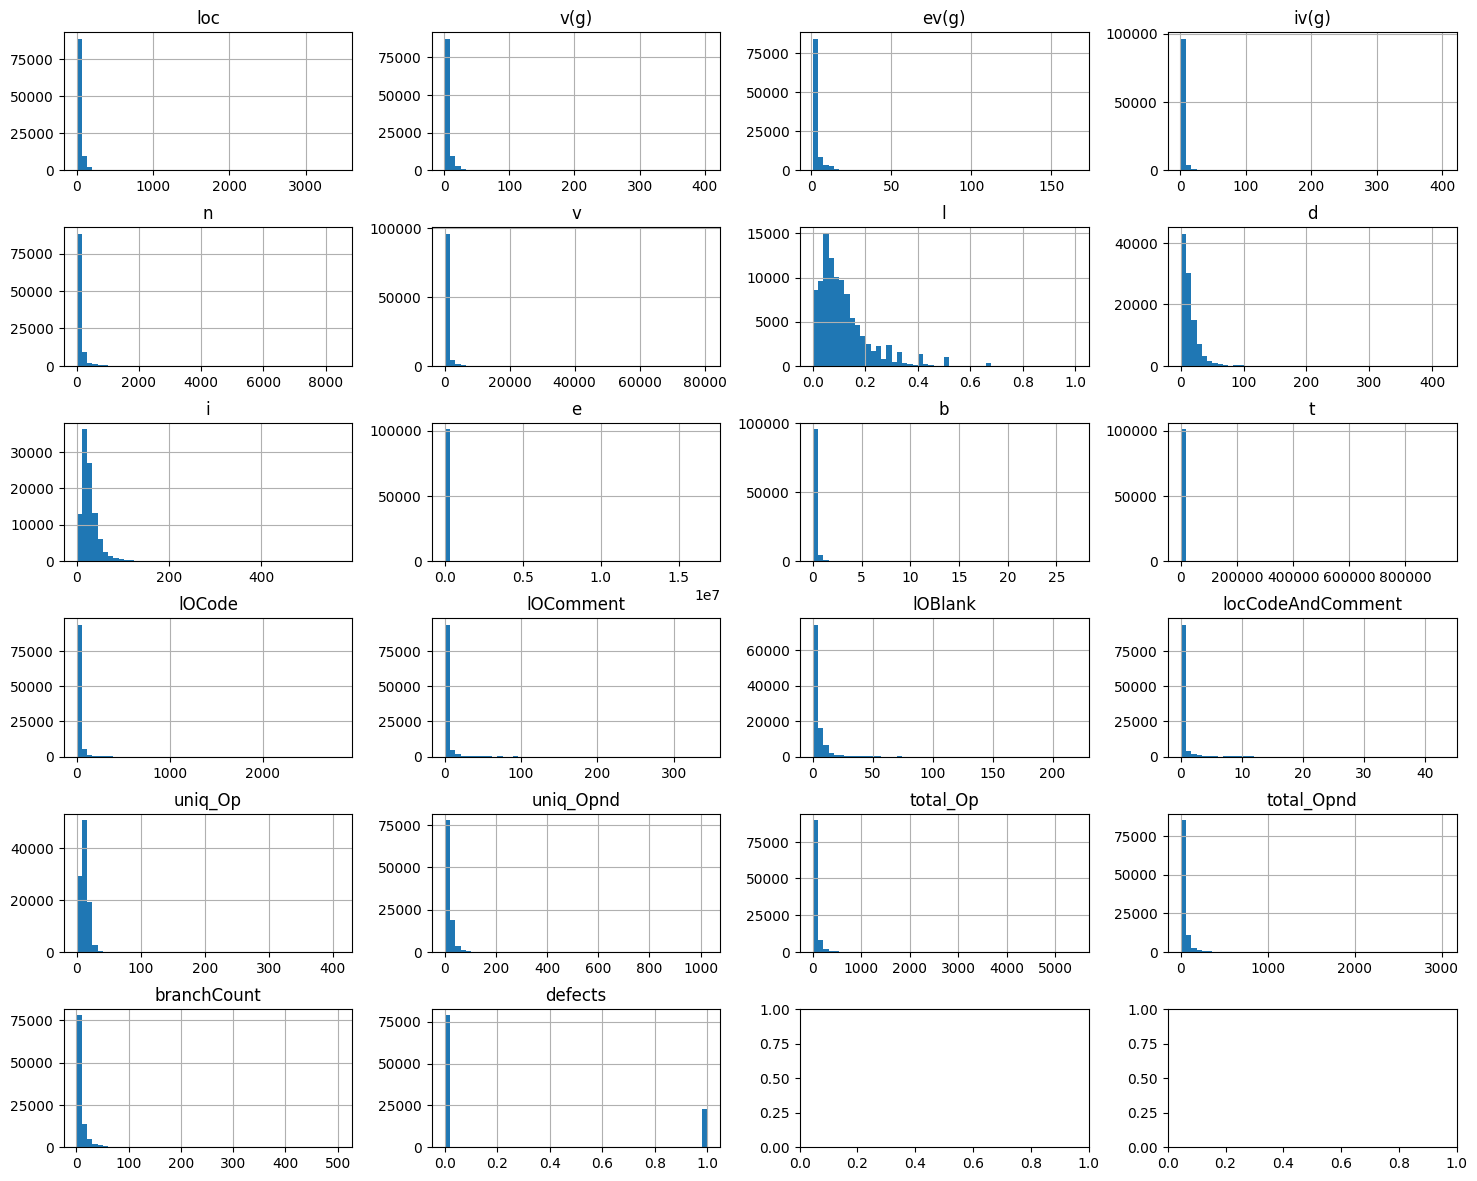

In [10]:
# Distribution plots for features
rows, cols = 6, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))
fig.tight_layout(pad=2.0)
axe = axes.ravel()

for i, feature in enumerate(df.columns):
    axe[i].set_title(feature)
    df[feature].hist(bins=50, ax=axe[i])

plt.show()

In [11]:
#Checking for class imbalance
class_counts = df['defects'].value_counts()
class_proportions = df['defects'].value_counts(normalize=True)
print("Class 0 count:", class_counts[0])
print("Class 1 count:", class_counts[1])

print("Class 0 proportion:", class_proportions[0])
print("Class 1 proportion:", class_proportions[1])



Class 0 count: 78699
Class 1 count: 23064
Class 0 proportion: 0.7733557383331859
Class 1 proportion: 0.22664426166681406


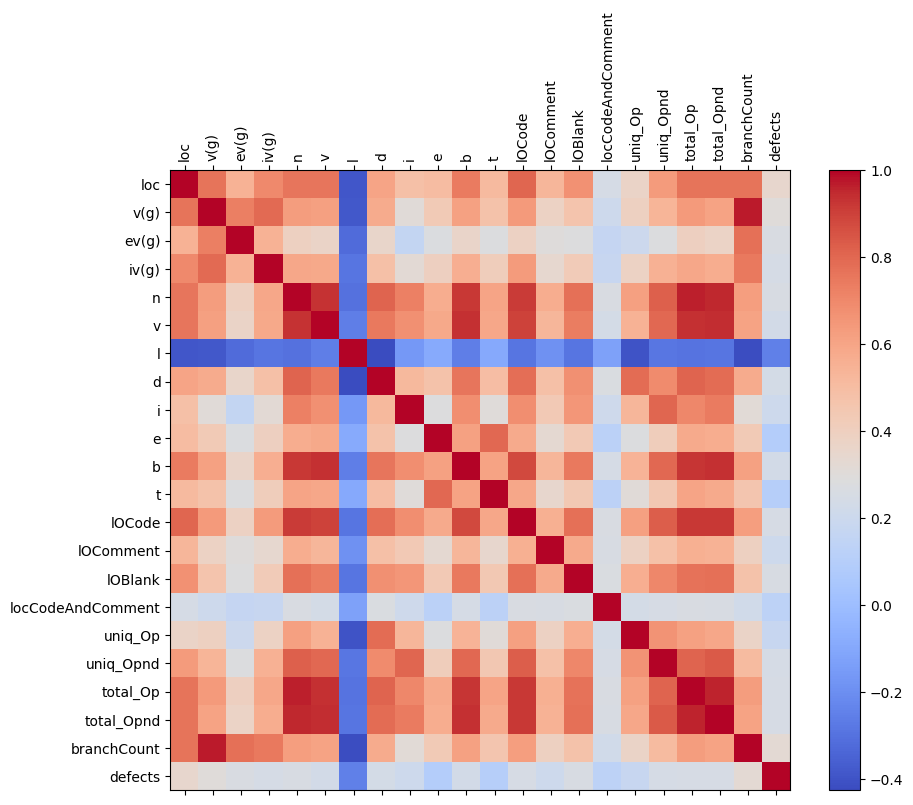

In [12]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.show()

In [13]:
#Based on the maximum values of the columns in the dataset, we can conclude that the range of values for different features varies significantly.
#We need to scale the data.
df.max()

loc                      3442.00
v(g)                      404.00
ev(g)                     165.00
iv(g)                     402.00
n                        8441.00
v                       80843.08
l                           1.00
d                         418.20
i                         569.78
e                    16846621.12
b                          26.95
t                      935923.39
lOCode                   2824.00
lOComment                 344.00
lOBlank                   219.00
locCodeAndComment          43.00
uniq_Op                   410.00
uniq_Opnd                1026.00
total_Op                 5420.00
total_Opnd               3021.00
branchCount               503.00
defects                     1.00
dtype: float64

## Model training

In [14]:
SEED=123

In [15]:
from sklearn.model_selection import train_test_split

target_column = 'defects'

X = df.drop(target_column, axis=1)
y = df[target_column]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # make sure to use stratify, dataset is inbalanced

### Baseline model

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score # read: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

baseline_model = DummyClassifier(strategy='stratified', random_state=SEED)

baseline_model.fit(X, y)

y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

acc_baseline = accuracy_score(y_test, y_pred)
roc_auc_baseline = roc_auc_score(y_test, y_pred_proba)

print(f'Baseline - Accuracy score: {acc_baseline:.4f}')
print(f'Baseline - ROC AUC: {roc_auc_baseline:.4f}')

Baseline - Accuracy score: 0.6490
Baseline - ROC AUC: 0.4971


### Training 8 classifiers with default hyperparameters
The following models have been selected:
*   Logistic Regression
*   Random Forest
*   Gradient Boosting
*   Decision Tree
*   Naive Bayes
*   K-Nearest Neighbors
*   XGBoost
*   AdaBoost

In [17]:
from sklearn.model_selection import train_test_split

target_column = 'defects'

X = df.drop(target_column, axis=1)
y = df[target_column]
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y) # make sure to use stratify, dataset is inbalanced

In [18]:
# Classifiers using default hyperparameters
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=100, random_state=SEED),
    "Random Forest": RandomForestClassifier(random_state=SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=SEED),
    "Decision Tree": DecisionTreeClassifier(random_state=SEED),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(random_state=SEED),
    "AdaBoost": AdaBoostClassifier(random_state=SEED),
}

In [19]:
# Data scalers

def get_scalers():
    scalers = {
        'minmax': [MinMaxScaler()],
        'standard': [StandardScaler()],
        'robust': [RobustScaler()],
        'noscaler': []
    }
    return scalers


In [20]:
k = 5
cv = StratifiedKFold(n_splits=k)

# Lists for storing training results
models_all = []
scaling_methods_all = []
cv_roc_aucs_all = []
roc_aucs_on_test = []

scalers = get_scalers()

# Loop through scalers
for name_scaling, scaling_method in scalers.items():
    print()
    print('Scaling method: ', name_scaling)

    # Loop through classifiers
    for name, classifier in classifiers.items():

        # Lists for results across CVs
        roc_aucs = []

        # Storing y_true and y_preds across all CV folds
        all_y_true = []
        all_y_preds = []

        classification_pipeline = make_pipeline(*scaling_method, clone(classifier))
        roc_aucs_scores = cross_val_score(classification_pipeline, X, y, cv=cv, scoring='roc_auc')
        cv_roc_auc = np.mean(roc_aucs_scores)

        # Evaluate classifier on test dataset. Make sure we create a new classifier object.
        classification_pipeline_for_test = make_pipeline(*scaling_method, clone(classifier))

        classification_pipeline_for_test.fit(X, y)
        y_pred_proba = classification_pipeline_for_test.predict_proba(X_test)[:, 1]
        roc_auc_on_test = roc_auc_score(y_test, y_pred_proba)

        print(f"Model: {name}, ROC-AUC CV: {cv_roc_auc:.4f}, ROC-AUC Test: {roc_auc_on_test:.4f}")

        # Add results to the lists
        models_all.append(name)
        scaling_methods_all.append(name_scaling)
        cv_roc_aucs_all.append(cv_roc_auc)
        roc_aucs_on_test.append(roc_auc_on_test)

print()
print('Done!')


Scaling method:  minmax
Model: Logistic Regression, ROC-AUC CV: 0.7747, ROC-AUC Test: 0.7712
Model: Random Forest, ROC-AUC CV: 0.7697, ROC-AUC Test: 0.7653
Model: Gradient Boosting, ROC-AUC CV: 0.7917, ROC-AUC Test: 0.7890
Model: Decision Tree, ROC-AUC CV: 0.6119, ROC-AUC Test: 0.6101
Model: Naive Bayes, ROC-AUC CV: 0.7695, ROC-AUC Test: 0.7643
Model: K-Nearest Neighbors, ROC-AUC CV: 0.7224, ROC-AUC Test: 0.7155
Model: XGBoost, ROC-AUC CV: 0.7819, ROC-AUC Test: 0.7823
Model: AdaBoost, ROC-AUC CV: 0.7896, ROC-AUC Test: 0.7869

Scaling method:  standard
Model: Logistic Regression, ROC-AUC CV: 0.7802, ROC-AUC Test: 0.7766
Model: Random Forest, ROC-AUC CV: 0.7693, ROC-AUC Test: 0.7656
Model: Gradient Boosting, ROC-AUC CV: 0.7917, ROC-AUC Test: 0.7890
Model: Decision Tree, ROC-AUC CV: 0.6095, ROC-AUC Test: 0.6063
Model: Naive Bayes, ROC-AUC CV: 0.7695, ROC-AUC Test: 0.7643
Model: K-Nearest Neighbors, ROC-AUC CV: 0.7236, ROC-AUC Test: 0.7142
Model: XGBoost, ROC-AUC CV: 0.7819, ROC-AUC Test:

In [21]:
results = pd.DataFrame()
results['scaling_method'] = scaling_methods_all
results['model'] = models_all
results['AUC_VC'] = cv_roc_aucs_all
results['AUC_TEST'] = roc_aucs_on_test

In [22]:
results.sort_values('AUC_TEST', ascending=False)[:10]

,scaling_method,model,AUC_VC,AUC_TEST
2,minmax,Gradient Boosting,0.791715,0.789037
26,noscaler,Gradient Boosting,0.791715,0.788995
18,robust,Gradient Boosting,0.791714,0.788995
10,standard,Gradient Boosting,0.791713,0.788994
31,noscaler,AdaBoost,0.789609,0.786944
23,robust,AdaBoost,0.789609,0.786944
7,minmax,AdaBoost,0.789632,0.786944
15,standard,AdaBoost,0.789609,0.786944
14,standard,XGBoost,0.781888,0.782330
30,noscaler,XGBoost,0.781888,0.782330


Conclusion:
Based on the cross-validation results, the best performing model with default hyperparameters is Gradient Boost (with standard scaler applied). We will continue with optimising this model.

## Model tuning

### Applying sampling techniques

We will check how differenty sampling techniques will impact the model performance.

In [26]:
# Here we calculate sampling strategy parameters
class_counts = y.value_counts()

existing_data_minority_majority_ratio = class_counts.min() / class_counts.max()

step = 0.25
start_ratio = existing_data_minority_majority_ratio + step
sampling_strategies = [r for r in np.arange(start_ratio, 1.0, step)] + [1.0]

In [27]:
k = 2 # reduce number of CV to speed up the search
cv = StratifiedKFold(n_splits=k)

# Pick the best peforming model
model = clone(classifiers["Gradient Boosting"])

samplers = {
    'oversample_random': RandomOverSampler(),
    'oversample_smote': SMOTE(),
    'oversample_adasyn': ADASYN(),
    'undersample_random': RandomUnderSampler(),
    'undersample_centroids': ClusterCentroids(),
    'underover_smoteenn': SMOTEENN(),
}

parameters = {
    'sampler': list(samplers.values()),
    'sampler__sampling_strategy': sampling_strategies
}

classification_pipeline = Pipeline([
    ('sampler', None),
    ('model', model)
])

grid_search = GridSearchCV(classification_pipeline, parameters, scoring='roc_auc', cv=cv, verbose=1).fit(X, y)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


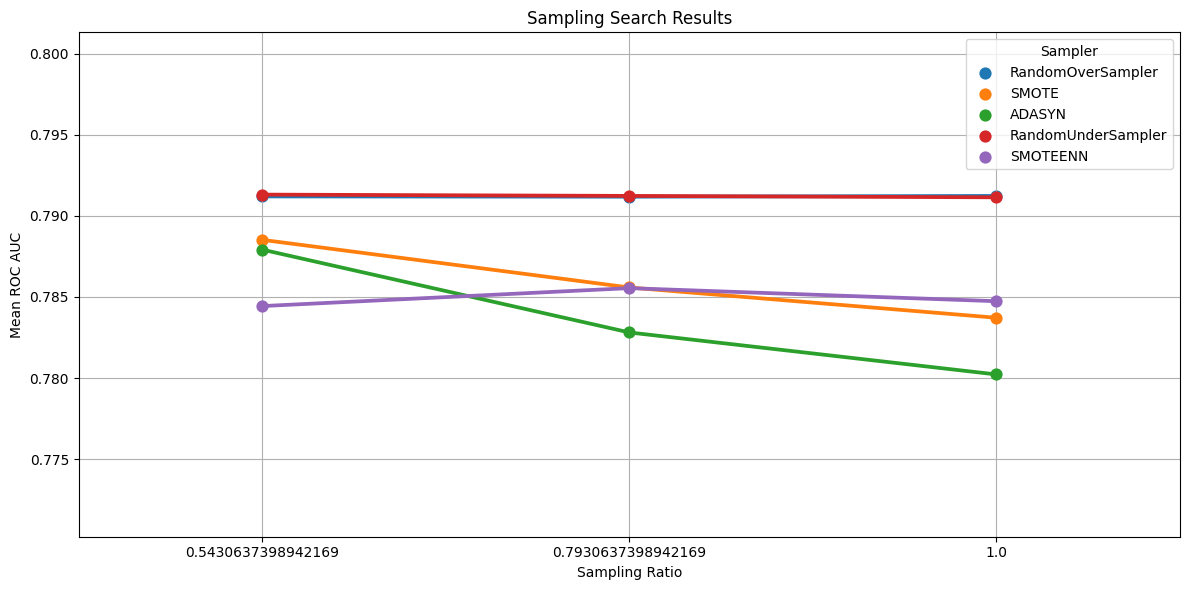

In [28]:
results = pd.DataFrame(grid_search.cv_results_)

results['strategy'] = results['param_sampler'].map(lambda x: x.__class__.__name__ if x is not None else 'None')

results = results[results['strategy'] != 'ClusterCentroids']

plt.figure(figsize=(12, 6))
sns.pointplot(data=results, x='param_sampler__sampling_strategy', y='mean_test_score', hue='strategy')

ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))  # Set format for y ticks

# Adjust the y-axis limits if necessary
plt.ylim(results['mean_test_score'].min() - 0.01, results['mean_test_score'].max() + 0.01)


plt.title('Sampling Search Results')
plt.xlabel('Sampling Ratio')
plt.ylabel('Mean ROC AUC')

plt.legend(title='Sampler')
plt.tight_layout()
plt.grid(True)
plt.show()

In [37]:
best_mean_auc = results['mean_test_score'].max()
best_row = results.loc[results['mean_test_score'].idxmax()]
best_sampler = best_row['param_sampler']
best_strategy = best_row['param_sampler__sampling_strategy']

print(f'Best Sampler: {best_sampler.__class__.__name__}')
print(f'Best Sampling Strategy: {best_strategy:.4f}')
print(f'Best Mean ROC AUC: {best_mean_auc:.4f}')


Best Sampler: RandomUnderSampler
Best Sampling Strategy: 0.5431
Best Mean ROC AUC: 0.7913


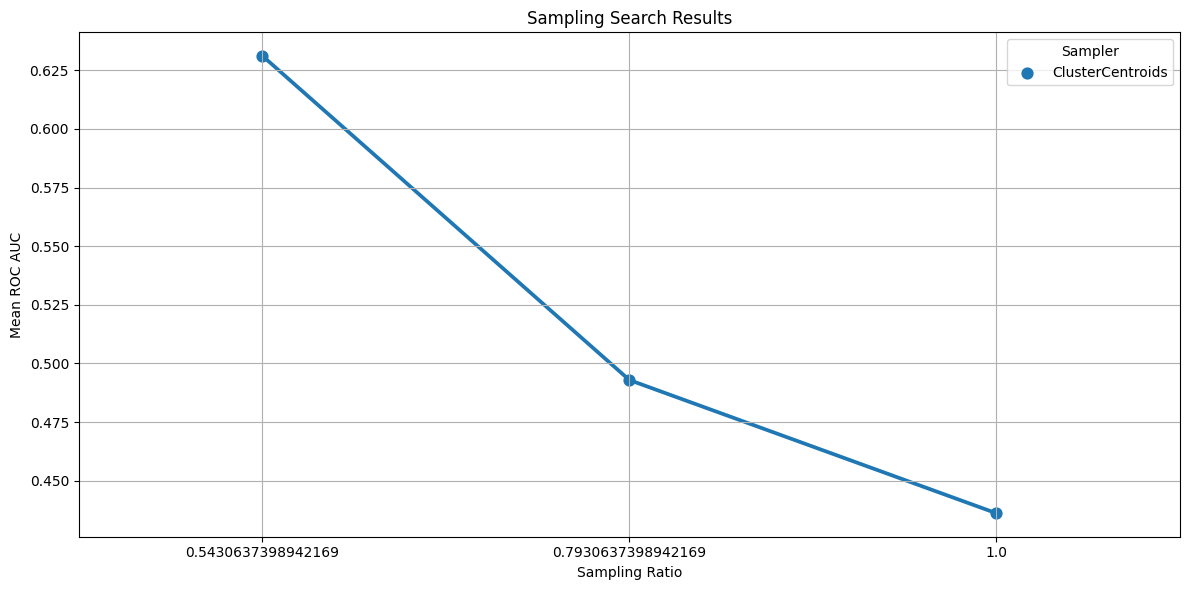

In [38]:
results = pd.DataFrame(grid_search.cv_results_)

results['strategy'] = results['param_sampler'].map(lambda x: x.__class__.__name__ if x is not None else 'None')

results = results[results['strategy'] == 'ClusterCentroids']

plt.figure(figsize=(12, 6))
sns.pointplot(data=results, x='param_sampler__sampling_strategy', y='mean_test_score', hue='strategy')

ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.3f'))  # Set format for y ticks

# Adjust the y-axis limits if necessary
plt.ylim(results['mean_test_score'].min() - 0.01, results['mean_test_score'].max() + 0.01)


plt.title('Sampling Search Results')
plt.xlabel('Sampling Ratio')
plt.ylabel('Mean ROC AUC')
# plt.ylim(results['mean_test_score'].min() * 0.95, results['mean_test_score'].max() * 1.05)

plt.legend(title='Sampler')
plt.tight_layout()
plt.grid(True)
plt.show()

Conclusion: None of the sampling methods has improved the model performance.

### Hyperparameter optimisation

We will try to find the best hyperparameter combination for GradientBoostingClassifier using the Hyperopt library.
The following hyperparameters can be optimsied:

*   n_estimators: The number of boosting stages to be run
*   learning_rate: The step size at each iteration
*   max_depth: The maximum depth of the individual trees
*   min_samples_split: The minimum number of samples required to split an internal node
*   min_samples_leaf: The minimum number of samples required to be at a leaf node
*   subsample: The fraction of samples used for fitting the individual trees

Due to the long execution time, only first three hyperparameters will be optimised.

In [45]:
# Define the objective function to minimize (negative ROC AUC for maximization)
def objective(params):
    params['n_estimators'] = int(params['n_estimators'])

    # Create a pipeline with the specified hyperparameters
    pipeline = make_pipeline(MinMaxScaler(), GradientBoostingClassifier(random_state=SEED, **params))

    # Perform cross-validation
    roc_auc = -cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1).mean()
    return roc_auc

# Define the hyperparameter search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', [3, 4, 5]),
}

# Keep track of the results
trials = Trials()

# Use Hyperopt to find the best hyperparameters
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best Hyperparameters:", best)
best_params = space_eval(space, best)


100%|██████████| 50/50 [29:34<00:00, 35.50s/trial, best loss: -0.7913216750263052]
Best Hyperparameters: {'learning_rate': 0.08616876108770292, 'max_depth': 1, 'n_estimators': 114.0}


In [51]:
# Create the final pipeline with the best hyperparameters
#best_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=SEED, **best_params))
#It is not possible to make a direct reference to the result of hyperopt, because running hyperopt takes 1-2 hours, so parameters are specified manually instead

best_params = {'learning_rate': 0.08616876108770292, 'max_depth': 1, 'n_estimators': 114}
best_pipeline = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=SEED, **best_params))

# Fit the best pipeline to the training data
best_pipeline.fit(X, y)

# Evaluate the best pipeline on the test set
y_test_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]
roc_auc_on_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Optimised ROC AUC on Test Set: {roc_auc_on_test:.4f}')

Optimised ROC AUC on Test Set: 0.7852


Conclusion: Hyperopt didn't improve the performance of GradientBoostingClassifier - the performance even slightly decreased.

# Final Results

| **Experiment**             | **ROC-AUC Train Set** | **ROC-AUC Test Set** | **Description**                  |
|----------------------------|-----------------------|----------------------|----------------------------------|
| DummyClassifier            | N/A                   | 0.4971               | Baseline                         |
| GradientBoostingClassifier | 0.7917                | 0.7890               | Default hyperparameters + minmax |
| RandomUnderSampler         | 0.7913                | N/A                  | Applying sampling techniques     |
| Hyperopt                   | 0.7913                | 0.7852               | Hyperparameter optimisation      |
| Kaggle Winner              | N/A                   | 0.79429              |                                  |

# Links

* Markdown table generator: https://www.tablesgenerator.com/markdown_tables
* ROC AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
